# Hierarchical timeseries

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

Here we use the tourism dataset with state-level aggregation.

In [2]:
from sktime.transformations.hierarchical.aggregate import Aggregator

data = pd.read_csv("tourism.csv")

data["Quarter"] = pd.PeriodIndex(data["Quarter"], freq="Q")
data = data.set_index(["Region", "Purpose", "State", "Quarter"])[["Trips"]]
data = data.sort_index()

y = (
    Aggregator(flatten_single_levels=False)
    .fit_transform(data)
    .groupby(level=[1,  -1])
    .sum()
)
y

Trips
Purpose  Quarter              
Business 1998Q1    7391.962068
         1998Q2    7701.153191
         1998Q3    8911.852065
         1998Q4    7777.766525
         1999Q1    6917.257864
...                        ...
__total  2015Q4   51518.858354
         2016Q1   54984.720748
         2016Q2   49583.595515
         2016Q3   49392.159616
         2016Q4   54034.155613

[380 rows x 1 columns]

In [22]:
LEVELS = y.index.get_level_values(0).unique()

def plot_preds(y=None, preds={}, axs=None):
    
    if axs is None:
        fig, axs = plt.subplots(figsize=(12, 8), nrows=int(np.ceil(len(LEVELS)/2)), ncols=2)
    ax_generator = iter(axs.flatten())
    for level in LEVELS:
        ax = next(ax_generator)
        if y is not None:
            y.loc[level].iloc[:, 0].rename("Observation").plot(ax=ax, label="truth", color="black")
        for name, _preds in preds.items():
            _preds.loc[level].iloc[:, 0].rename(name).plot(ax=ax, legend=True)
        ax.set_title(level)
        
    # Tight layout
    plt.tight_layout()
    return ax

# Fit univariate model

Because of sktime's amazing interface, we can use the univariate Prophet seamlessly with hierarchical data. We do not reconcile it here, but it could be achieved with the `Reconciler` class.

In [11]:
from prophetverse.sktime.univariate import Prophet
from prophetverse.sktime.seasonality import seasonal_transformer
model = Prophet(
    trend="logistic",
    capacity_prior_loc=1,
    capacity_prior_scale=0.5,
    changepoint_interval=8,
    changepoint_range=-8,
    changepoint_prior_scale=0.01,
    feature_transformer=seasonal_transformer(freq="Q", yearly_seasonality=10),
    default_effect_mode="multiplicative",
    default_exogenous_prior=("Normal", 0, 0.1),
    # exogenous_effects={"sin": ("^sin_.*", LinearEffect("sin", effect_mode="multiplicative"))},
    noise_scale=0.05,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
    optimizer_steps=20000,
)
model.fit(y=y)

100%|██████████| 20000/20000 [00:01<00:00, 12218.08it/s, init loss: 7252.0127, avg. loss [19001-20000]: -233.7731]


Prophet(capacity_prior_loc=1, capacity_prior_scale=0.5, changepoint_interval=8,
        changepoint_prior_scale=0.01, changepoint_range=-8,
        default_exogenous_prior=('Normal', 0, 0.1),
        feature_transformer=FourierFeatures(fourier_terms_list=[10], freq='Q',
                                            sp_list=['Y']),
        mcmc_chains=1, mcmc_samples=300, mcmc_warmup=3000,
        optimizer_steps=20000, trend='logistic')

## Forecasting

In [12]:
y

Trips
Purpose  Quarter              
Business 1998Q1    7391.962068
         1998Q2    7701.153191
         1998Q3    8911.852065
         1998Q4    7777.766525
         1999Q1    6917.257864
...                        ...
__total  2015Q4   51518.858354
         2016Q1   54984.720748
         2016Q2   49583.595515
         2016Q3   49392.159616
         2016Q4   54034.155613

[380 rows x 1 columns]

<Axes: title={'center': '__total'}, xlabel='Quarter'>

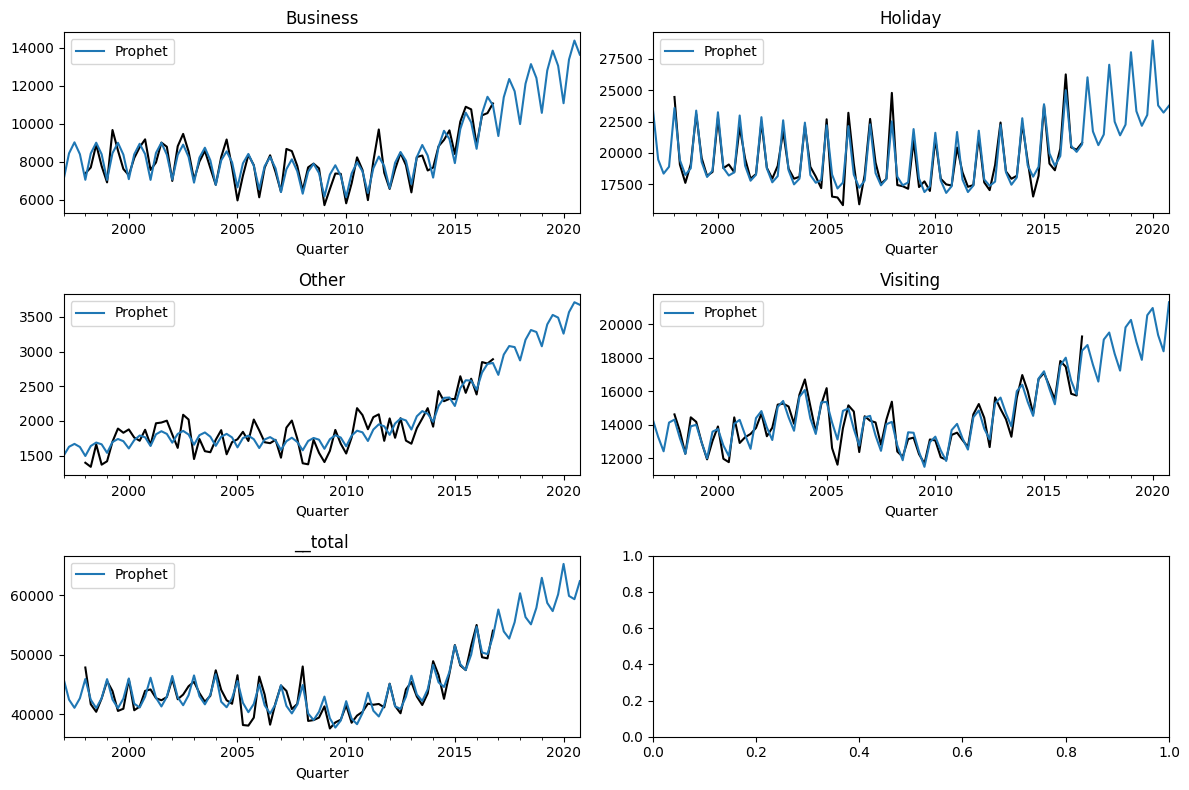

In [13]:
forecast_horizon = pd.period_range("1997Q1", "2020Q4", freq="Q")
preds = model.predict(fh=forecast_horizon)
plot_preds(y, {"Prophet": preds})

## Hierarchical Prophet

Now, let's use the hierarchical prophet to forecast all of the series at once. In addition, we will use the logistic growth model.

In [14]:
from prophetverse.sktime.multivariate import HierarchicalProphet
from prophetverse.effects import LinearEffect


model_hier = HierarchicalProphet(
    trend="logistic",
    changepoint_prior_scale=0.1,
    capacity_prior_loc=1.5,
    capacity_prior_scale=3,
    feature_transformer=FourierFeatures(fourier_terms_list=[4], sp_list=["Y"]),
    # shared_features=["^(sin).*", "^(cos).*"],
    changepoint_interval=10,
    changepoint_range=-8,
    noise_scale=0.05,
    exogenous_effects={
        "seasonality": (
            r"^(sin_|cos_).*",
            LinearEffect("sin", effect_mode="multiplicative", prior=(dist.Normal, 0, .1)),
        )
    },
    default_effect_mode="multiplicative",
    default_exogenous_prior=("Normal", 0, 1),
    #optimizer_kwargs={"init_value": 1e-5, "decay_steps": 300_000, "alpha": 1e-5},
    optimizer_kwargs={"step_size": 1e-4},
    optimizer_name="Adam",
    inference_method="map",
    optimizer_steps=300_000,
    correlation_matrix_concentration=2,
)


model_hier.fit(y=y)

100%|██████████| 300000/300000 [00:26<00:00, 11151.21it/s, init loss: 243303497728.0000, avg. loss [285001-300000]: -646.9141] 


HierarchicalProphet(capacity_prior_loc=1.5, capacity_prior_scale=3,
                    changepoint_interval=10, changepoint_range=-8,
                    correlation_matrix_concentration=2,
                    exogenous_effects={'seasonality': ('^(sin_|cos_).*',
                                                       <prophetverse.effects.LinearEffect object at 0x2afb8e990>)},
                    feature_transformer=FourierFeatures(fourier_terms_list=[4],
                                                        sp_list=['Y']),
                    mcmc_chains=1, mcmc_samples=500, mcmc_warmup=3000,
                    optimizer_steps=300000, trend='logistic')

## Forecasting with hierarchical prophet

<Axes: title={'center': '__total'}, xlabel='Quarter'>

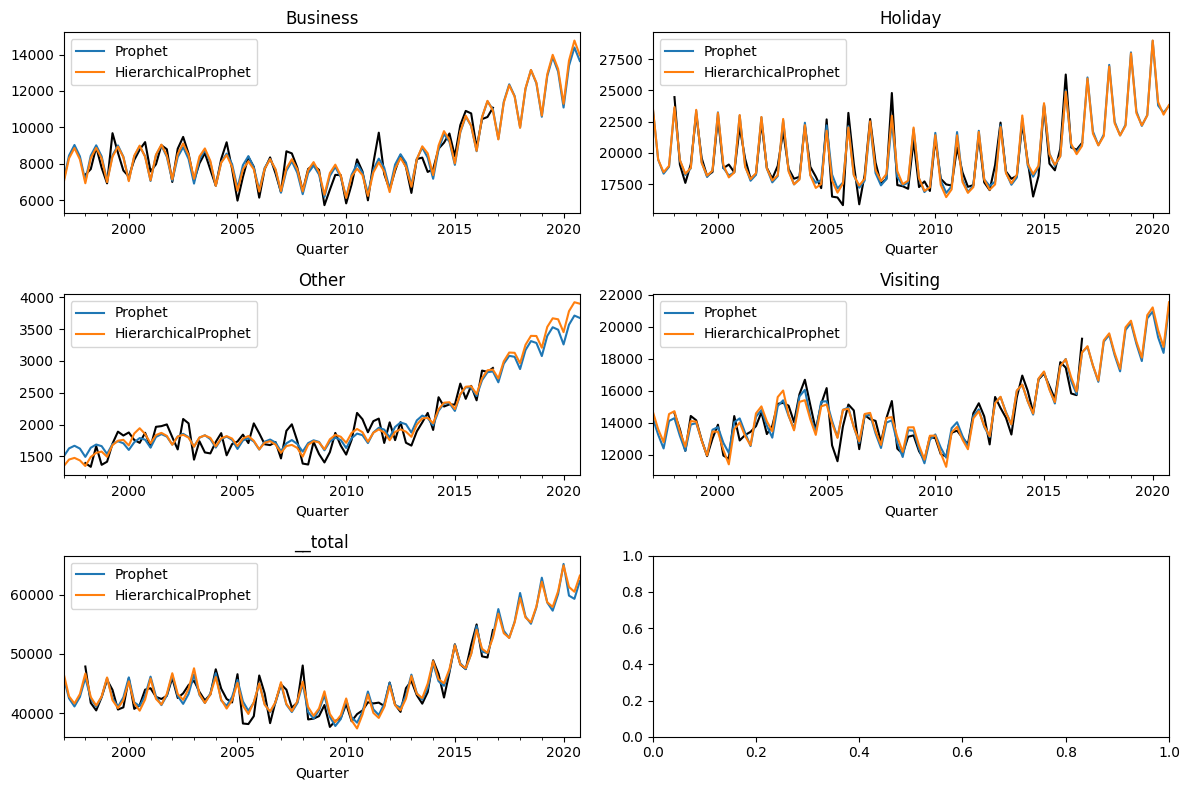

In [15]:
preds_hier = model_hier.predict(fh=forecast_horizon)

plot_preds(
    y,
    preds={
        "Prophet": preds,
        "HierarchicalProphet": preds_hier,
    },
)

In [18]:
sites[column]

Purpose   Quarter
Business  1997Q1      6944.051028
          1997Q2      9991.898091
          1997Q3      5154.064478
          1997Q4      8469.541500
          1998Q1      8293.399813
                         ...     
Visiting  2019Q4     18752.415178
          2020Q1     24280.363282
          2020Q2     17477.728183
          2020Q3     25993.452580
          2020Q4     21545.900743
Name: obs, Length: 384, dtype: float64

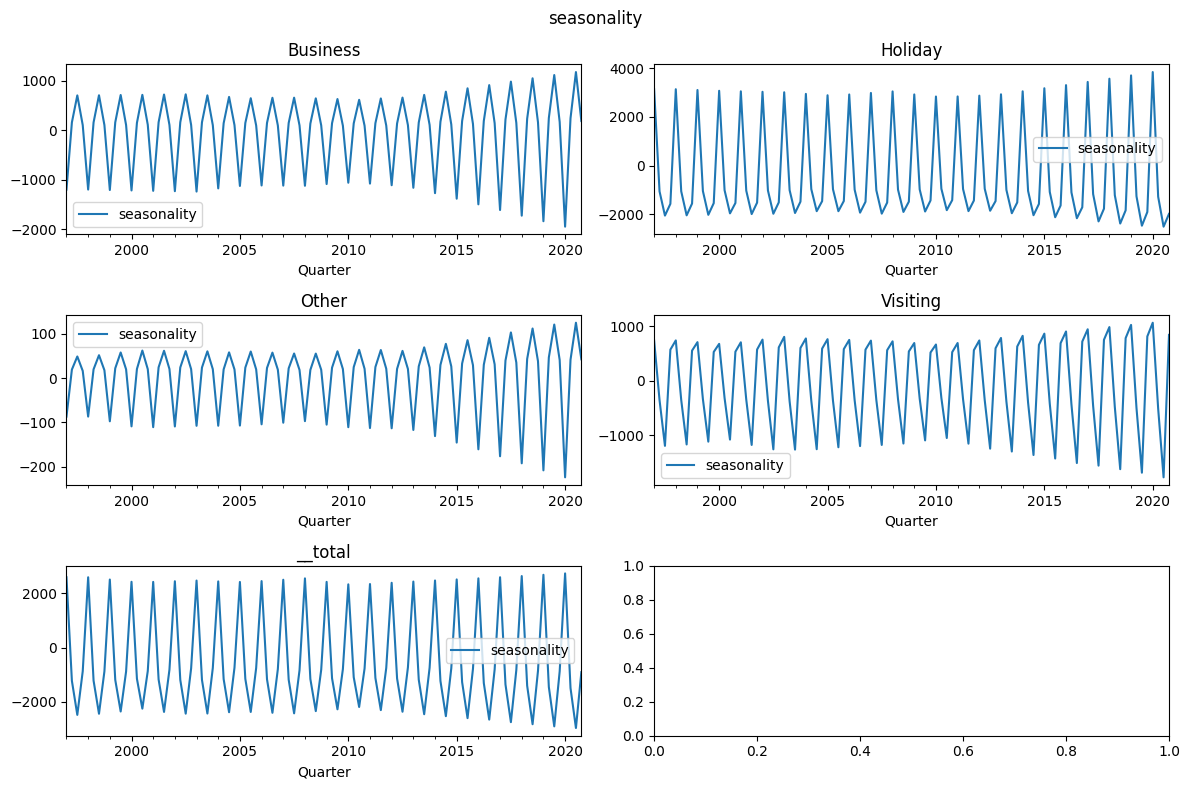

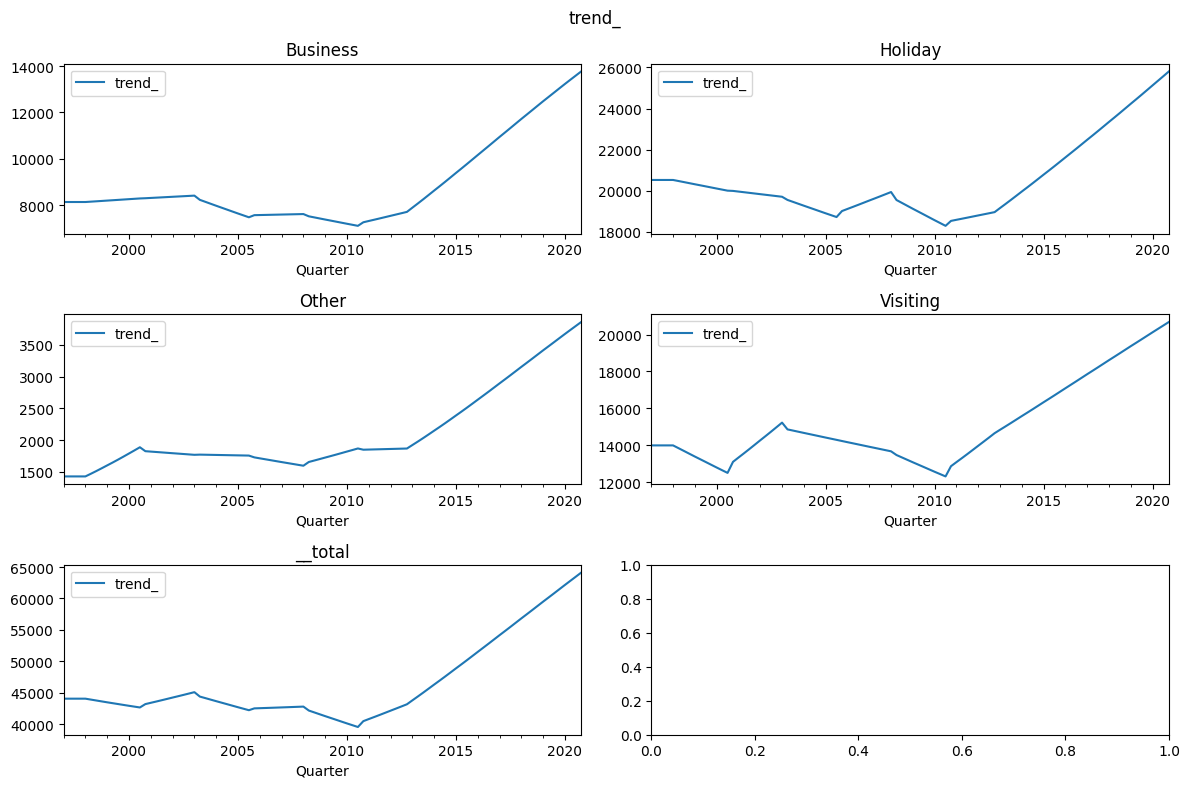

In [29]:
from sktime.transformations.hierarchical.aggregate import Aggregator
sites = model_hier.predict_all_sites(fh=forecast_horizon)
sites = Aggregator(flatten_single_levels=True).fit_transform(sites)

for column in sites.columns.difference(["obs"]):
    fig, axs = plt.subplots(
        figsize=(12, 8), nrows=int(np.ceil(len(LEVELS) / 2)), ncols=2
    )
    plot_preds(preds={column: sites[[column]]}, axs=axs)
    # Set figure title
    fig.suptitle(column)
    fig.tight_layout()